# import

In [1]:
import os
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from tensorflow.compat.v1.logging import set_verbosity, ERROR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import kstest, gaussian_kde, ks_2samp, chi2_contingency, wasserstein_distance
from sdv.metadata import MultiTableMetadata
# from sdv.single_table import CTGANSynthesizer
# from sdv.single_table import CopulaGANSynthesizer
# from sdv.single_table import GaussianCopulaSynthesizer
# from sdv.single_table import TVAESynthesizer
# from sdv.lite import SingleTablePreset
from sdv.multi_table import HMASynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.multi_table import evaluate_quality
from sdv.evaluation.multi_table import run_diagnostic

In [2]:
set_verbosity(ERROR)

# load data

In [3]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path) if f.endswith('.csv') or f.endswith('.txt')]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if data.shape[0] > 1:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [4]:
real_data_collection = load_data_collection("gtfs")

In [5]:
del real_data_collection['shapes']

## Create Metadata

In [6]:
def auto_detect_relation(data_collection):
    metadata = {}
    for df_name, df in data_collection.items():
        parent = {}
        child = []
        primary_key = []
        foreign_key = []
        for col in df.columns:
            if 'id' in col:
                if df[col].nunique() == len(df):
                    primary_key = [col, len(df)]
                else:
                    foreign_key.append(col)
        for foreign_df_name, foreign_df in data_collection.items():
            if foreign_df_name != df_name:
                for fr_col in foreign_df.columns:
                    if 'id' in fr_col:
                        for fr_k in foreign_key:
                            if fr_col == fr_k and foreign_df[fr_col].nunique() == len(foreign_df):
                                parent[foreign_df_name] = fr_k
                        if primary_key != []:
                            if fr_col == primary_key[0] and foreign_df[fr_col].nunique() != len(foreign_df):
                                child.append(foreign_df_name)
        metadata[df_name] = {'primary_key':primary_key,
                             'parent':parent,
                             'child':child,
                             'is_sequential':False,
                            'additional_key':None}
    return metadata

In [7]:
metadata = auto_detect_relation(real_data_collection)
metadata['calendar_dates']['is_sequential'] = True
metadata['stop_times']['is_sequential'] = True
metadata['calendar_dates']['additional_key'] = ['date']
metadata['stop_times']['additional_key'] = ['stop_sequence']
metadata['calendar_dates']['sort_order'] = ['service_id','date']
metadata['stop_times']['sort_order'] = ['trip_id','stop_sequence']

In [8]:
metadata

{'agency': {'primary_key': ['agency_id', 15],
  'parent': {},
  'child': ['routes'],
  'is_sequential': False,
  'additional_key': None},
 'calendar': {'primary_key': ['service_id', 121],
  'parent': {},
  'child': ['calendar_dates', 'trips'],
  'is_sequential': False,
  'additional_key': None},
 'calendar_dates': {'primary_key': [],
  'parent': {'calendar': 'service_id'},
  'child': [],
  'is_sequential': True,
  'additional_key': ['date'],
  'sort_order': ['service_id', 'date']},
 'routes': {'primary_key': ['route_id', 215],
  'parent': {'agency': 'agency_id'},
  'child': ['trips'],
  'is_sequential': False,
  'additional_key': None},
 'stops': {'primary_key': ['stop_id', 6714],
  'parent': {},
  'child': ['stop_times'],
  'is_sequential': False,
  'additional_key': None},
 'stop_times': {'primary_key': [],
  'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
  'child': [],
  'is_sequential': True,
  'additional_key': ['stop_sequence'],
  'sort_order': ['trip_id', 'stop_sequence']},

In [9]:
# {'agency': {'primary_key': ['agency_id', 15],
#   'parent': {},
#   'child': ['routes']},
#  'calendar': {'primary_key': ['service_id', 121],
#   'parent': {},
#   'child': ['calendar_dates', 'trips']},
#  'calendar_dates': {'primary_key': [],
#   'parent': {'calendar': 'service_id'},
#   'child': []},
#  'routes': {'primary_key': ['route_id', 215],
#   'parent': {'agency': 'agency_id'},
#   'child': ['trips']},
#  'stops': {'primary_key': ['stop_id', 6714],
#   'parent': {},
#   'child': ['stop_times']},
#  'stop_times': {'primary_key': [],
#   'parent': {'stops': 'stop_id', 'trips': 'trip_id'},
#   'child': []},
#  'trips': {'primary_key': ['trip_id', 32403],
#   'parent': {'calendar': 'service_id', 'routes': 'route_id'},
#   'child': ['stop_times']}}

# preprocess

## Create Factorization Dictionary:

In [10]:
def create_factorization_dict(data_collection, metadata):
    factor_dict = {}
    for df_name, df in data_collection.items():
        local_id_dict = {}
        primary_key_info = metadata[df_name]['primary_key']
        if primary_key_info != []:
            local_id_dict = {k:v for v,k in enumerate(df[primary_key_info[0]].unique())}
            factor_dict[primary_key_info[0]] = local_id_dict
    return factor_dict

In [11]:
factorization_dict = create_factorization_dict(real_data_collection, metadata)

## Format Individual Table:

In [12]:
def individual_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [13]:
def format_individual_data(data, preprocess_dict, factorization_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            if col in factorization_dict.keys():
                                data[col] = data[col].map(factorization_dict[col])
                            else:
                                data[col] = pd.factorize(data[col], sort=True)[0]
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

## preprocess individual data

In [14]:
sdv_metadata = MultiTableMetadata()

In [15]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_name','agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id','agency_url','agency_timezone','agency_lang','agency_phone']
real_data_collection['agency'] = format_individual_data(real_data_collection['agency'], preprocess_dict, factorization_dict)

In [16]:
sdv_metadata.detect_table_from_dataframe(table_name='agency', data=real_data_collection['agency'])
sdv_metadata.update_column(table_name='agency',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='agency',column_name='agency_url',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_timezone',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_lang',sdtype='categorical')
sdv_metadata.update_column(table_name='agency',column_name='agency_phone',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='agency',column_name='agency_id')

### calendar

In [17]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = format_individual_data(real_data_collection['calendar'], preprocess_dict, factorization_dict)

In [18]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar',data=real_data_collection['calendar'])
sdv_metadata.update_column(table_name='calendar',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar',column_name='monday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='tuesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='wednesday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='thursday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='friday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='saturday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='sunday',sdtype='categorical')
sdv_metadata.update_column(table_name='calendar',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='calendar',column_name='service_id')

### calendar_dates

In [19]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = format_individual_data(real_data_collection['calendar_dates'], preprocess_dict, factorization_dict)

In [20]:
sdv_metadata.detect_table_from_dataframe(table_name='calendar_dates',data=real_data_collection['calendar_dates'])
sdv_metadata.update_column(table_name='calendar_dates',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='calendar_dates',column_name='date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='calendar_dates',column_name='exception_type',sdtype='categorical')

### routes

In [21]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_short_name','route_long_name','route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = format_individual_data(real_data_collection['routes'], preprocess_dict, factorization_dict)

In [22]:
real_data_collection['routes']['route_color'] = real_data_collection['routes']['route_color'].astype(int)
real_data_collection['routes']['route_text_color'] = real_data_collection['routes']['route_text_color'].astype(int)

In [23]:
sdv_metadata.detect_table_from_dataframe(table_name='routes',data=real_data_collection['routes'])
sdv_metadata.update_column(table_name='routes',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='agency_id',sdtype='id')
sdv_metadata.update_column(table_name='routes',column_name='route_type',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='route_text_color',sdtype='categorical')
sdv_metadata.update_column(table_name='routes',column_name='contract_id',sdtype='id')
sdv_metadata.set_primary_key(table_name='routes',column_name='route_id')

### stops

In [24]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_name','stop_code','stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = format_individual_data(real_data_collection['stops'], preprocess_dict, factorization_dict)

In [25]:
real_data_collection['stops']['parent_station'] = real_data_collection['stops']['parent_station'].astype(int)
real_data_collection['stops']['platform_code'] = real_data_collection['stops']['platform_code'].astype(int)

In [26]:
sdv_metadata.detect_table_from_dataframe(table_name='stops',data=real_data_collection['stops'])
sdv_metadata.update_column(table_name='stops',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stops',column_name='stop_lat',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='stop_lon',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stops',column_name='location_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='parent_station',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='platform_code',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='wheelchair_boarding',sdtype='categorical')
sdv_metadata.update_column(table_name='stops',column_name='start_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stops',column_name='end_date',sdtype='numerical',computer_representation='Int32')
sdv_metadata.set_primary_key(table_name='stops',column_name='stop_id')

### stop_times

In [27]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = format_individual_data(real_data_collection['stop_times'], preprocess_dict, factorization_dict)

In [28]:
real_data_collection['stop_times']['arrival_time'] = real_data_collection['stop_times']['arrival_time'].astype(int)
real_data_collection['stop_times']['departure_time'] = real_data_collection['stop_times']['departure_time'].astype(int)

In [29]:
sdv_metadata.detect_table_from_dataframe(table_name='stop_times',data=real_data_collection['stop_times'])
sdv_metadata.update_column(table_name='stop_times',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='arrival_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='departure_time',sdtype='numerical',computer_representation='Int32')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_id',sdtype='id')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_sequence',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='stop_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='pickup_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='drop_off_type',sdtype='categorical')
sdv_metadata.update_column(table_name='stop_times',column_name='shape_dist_traveled',sdtype='numerical',computer_representation='Float')
sdv_metadata.update_column(table_name='stop_times',column_name='timepoint',sdtype='categorical')

### trips

In [30]:
preprocess_dict = individual_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = format_individual_data(real_data_collection['trips'], preprocess_dict, factorization_dict)

In [31]:
sdv_metadata.detect_table_from_dataframe(table_name='trips',data=real_data_collection['trips'])
sdv_metadata.update_column(table_name='trips',column_name='route_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='service_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='trip_headsign',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='direction_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='shape_id',sdtype='id')
sdv_metadata.update_column(table_name='trips',column_name='wheelchair_accessible',sdtype='categorical')
sdv_metadata.update_column(table_name='trips',column_name='bikes_allowed',sdtype='categorical')
sdv_metadata.set_primary_key(table_name='trips',column_name='trip_id')

## Add SDV Relations

In [32]:
sdv_metadata.add_relationship(
    parent_table_name='agency',
    child_table_name='routes',
    parent_primary_key='agency_id',
    child_foreign_key='agency_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='calendar_dates',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='calendar',
    child_table_name='trips',
    parent_primary_key='service_id',
    child_foreign_key='service_id'
)

sdv_metadata.add_relationship(
    parent_table_name='routes',
    child_table_name='trips',
    parent_primary_key='route_id',
    child_foreign_key='route_id'
)

sdv_metadata.add_relationship(
    parent_table_name='stops',
    child_table_name='stop_times',
    parent_primary_key='stop_id',
    child_foreign_key='stop_id'
)

sdv_metadata.add_relationship(
    parent_table_name='trips',
    child_table_name='stop_times',
    parent_primary_key='trip_id',
    child_foreign_key='trip_id'
)

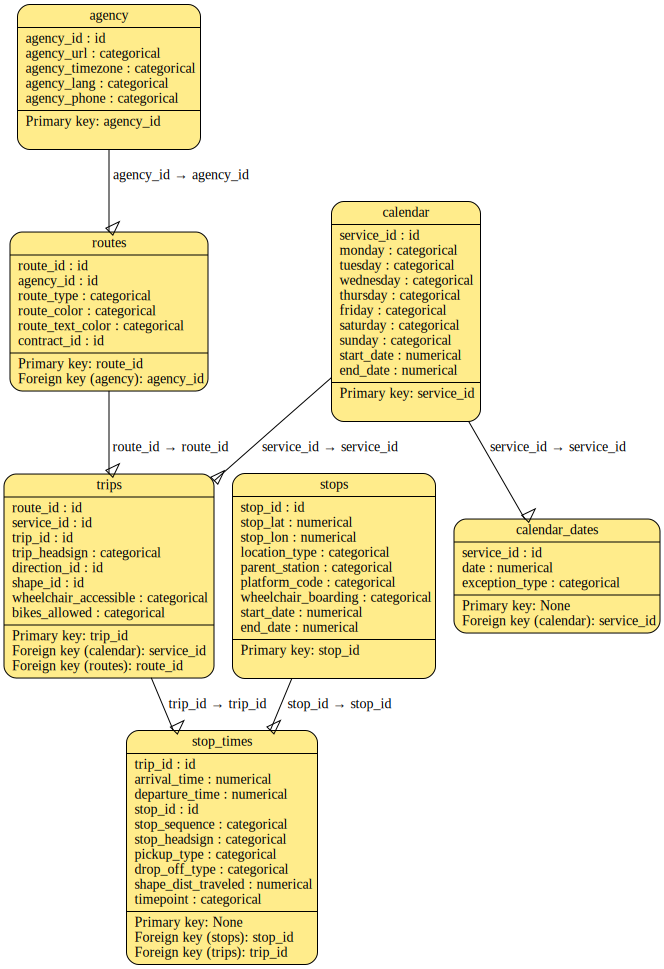

In [33]:
sdv_metadata.visualize()

In [34]:
# sdv_metadata.add_relationship(
#     parent_table_name='agency',
#     child_table_name='routes',
#     parent_primary_key='agency_id',
#     child_foreign_key='agency_id'
# )

# sdv_metadata.add_relationship(
#     parent_table_name='calendar',
#     child_table_name='calendar_dates',
#     parent_primary_key='service_id',
#     child_foreign_key='service_id'
# )

# sdv_metadata.add_relationship(
#     parent_table_name='calendar',
#     child_table_name='trips',
#     parent_primary_key='service_id',
#     child_foreign_key='service_id'
# )

# sdv_metadata.add_relationship(
#     parent_table_name='routes',
#     child_table_name='trips',
#     parent_primary_key='route_id',
#     child_foreign_key='route_id'
# )

# sdv_metadata.add_relationship(
#     parent_table_name='stops',
#     child_table_name='stop_times',
#     parent_primary_key='stop_id',
#     child_foreign_key='stop_id'
# )

# sdv_metadata.add_relationship(
#     parent_table_name='trips',
#     child_table_name='stop_times',
#     parent_primary_key='trip_id',
#     child_foreign_key='trip_id'
# )

In [35]:
sdv_metadata.relationships

[{'parent_table_name': 'agency',
  'child_table_name': 'routes',
  'parent_primary_key': 'agency_id',
  'child_foreign_key': 'agency_id'},
 {'parent_table_name': 'calendar',
  'child_table_name': 'calendar_dates',
  'parent_primary_key': 'service_id',
  'child_foreign_key': 'service_id'},
 {'parent_table_name': 'calendar',
  'child_table_name': 'trips',
  'parent_primary_key': 'service_id',
  'child_foreign_key': 'service_id'},
 {'parent_table_name': 'routes',
  'child_table_name': 'trips',
  'parent_primary_key': 'route_id',
  'child_foreign_key': 'route_id'},
 {'parent_table_name': 'stops',
  'child_table_name': 'stop_times',
  'parent_primary_key': 'stop_id',
  'child_foreign_key': 'stop_id'},
 {'parent_table_name': 'trips',
  'child_table_name': 'stop_times',
  'parent_primary_key': 'trip_id',
  'child_foreign_key': 'trip_id'}]

## Obtain Foreign Key Distribution

In [36]:
def get_distribution(array):
    unique_elements, counts = np.unique(array, return_counts=True)
    prob_distribution = counts / counts.sum()
    return unique_elements, prob_distribution

In [37]:
def add_fr_key_pdf(data_collection, metadata):
    for df_name, content in metadata.items():
        key_pdf = {}
        if content['parent'] != {}:
            for parent_df_name, fr_k in content['parent'].items():
                unique_val, pdf = get_distribution(data_collection[parent_df_name][fr_k])
                key_pdf[fr_k] = {'unique_values':unique_val,'pdf':pdf}
        if content['is_sequential'] == True:
            for additional_key in content['additional_key']:
                unique_val, pdf = get_distribution(data_collection[df_name][additional_key])
                key_pdf[additional_key] = {'unique_values':unique_val,'pdf':pdf}
        metadata[df_name]['key_distribution'] = key_pdf

In [38]:
add_fr_key_pdf(real_data_collection, metadata)

In [39]:
metadata

{'agency': {'primary_key': ['agency_id', 15],
  'parent': {},
  'child': ['routes'],
  'is_sequential': False,
  'additional_key': None,
  'key_distribution': {}},
 'calendar': {'primary_key': ['service_id', 121],
  'parent': {},
  'child': ['calendar_dates', 'trips'],
  'is_sequential': False,
  'additional_key': None,
  'key_distribution': {}},
 'calendar_dates': {'primary_key': [],
  'parent': {'calendar': 'service_id'},
  'child': [],
  'is_sequential': True,
  'additional_key': ['date'],
  'sort_order': ['service_id', 'date'],
  'key_distribution': {'service_id': {'unique_values': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
            13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
            26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
            39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
            52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
            65,  66,  67,  68, 

## Scaling

In [40]:
def scale_individual_df(df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(df)
    scaled_df = pd.DataFrame(scaler.transform(df), columns = df.columns)
    return scaled_df, scaler

In [41]:
def extract_key_and_scaled_features(df, label_columns):
    labels = df[label_columns]
    table = df.drop(columns=label_columns)
    table_column_names = table.columns
    scaled_table, table_scaler = scale_individual_df(table)
    scaled_labels, labels_scaler = scale_individual_df(labels)
    return scaled_table, scaled_labels, table_scaler, labels_scaler, table_column_names

In [42]:
def batch_scaling(data_collection, metadata):
    processed_data_collection = {}
    for df_name, df in data_collection.items():
        primary_key = []
        foreign_key = []
        if metadata[df_name]['primary_key'] != []:
            primary_key = [metadata[df_name]['primary_key'][0]]
        if metadata[df_name]['parent'] != {}:
            foreign_key = list(metadata[df_name]['parent'].values())
        if metadata[df_name]['is_sequential'] == True:
            additional_key = list(metadata[df_name]['additional_key'])
            label_columns = primary_key + foreign_key + additional_key
        else:
            label_columns = primary_key + foreign_key
        table, labels, table_scaler, labels_scaler, table_columns = extract_key_and_scaled_features(df, label_columns)
        processed_data_collection[df_name] = {'table':table,
                                              'labels':labels,
                                              'table_scaler':table_scaler,
                                              'labels_scaler':labels_scaler,
                                              'table_col_names':table_columns,
                                              'labels_col_names':label_columns,
                                              'col_names':df.columns,
                                             'metadata':metadata[df_name]}
    return processed_data_collection

In [43]:
processed_data_collection = batch_scaling(real_data_collection, metadata)

# Main GAN Algorithm

## Additional Custom Function (Wasserstein Loss)

In [44]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [45]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [46]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(discriminator_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, Discriminator

## Normal

In [47]:
def build_generator(table_dim, labels_dim, latent_dim=50):
    init = initializers.HeUniform()
    noise_input = layers.Input(shape=(latent_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(merge_input)
    hidden_layer1 = layers.Dense(128,activation='LeakyReLU',kernel_initializer=init)(bn_layer1)
    hidden_layer2 = layers.Dense(256,activation='LeakyReLU',kernel_initializer=init)(hidden_layer1)
    hidden_layer3 = layers.Dense(512,activation='LeakyReLU',kernel_initializer=init)(hidden_layer2)
    bn_layer2 = layers.BatchNormalization()(hidden_layer3)
    output_layer = layers.Dense(table_dim, activation='tanh',kernel_initializer='glorot_uniform')(bn_layer2)
    generator = models.Model([noise_input, labels_input], output_layer)
    return generator

In [48]:
def build_critic(table_dim, labels_dim, constraint_rate=0.01, optimization_rate=0.00005):
    clip_const = ClipConstraint(constraint_rate)
    opt = optimizers.RMSprop(optimization_rate)
    init = initializers.HeUniform()
    table_input = layers.Input(shape=(table_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    bn_layer1 = layers.BatchNormalization()(merge_input)
    hidden_layer1 = layers.Dense(512,activation='LeakyReLU',kernel_constraint=clip_const,kernel_initializer=init)(bn_layer1)
    hidden_layer2 = layers.Dense(256,activation='LeakyReLU',kernel_constraint=clip_const,kernel_initializer=init)(hidden_layer1)
    hidden_layer3 = layers.Dense(128,activation='LeakyReLU',kernel_constraint=clip_const,kernel_initializer=init)(hidden_layer2)
    bn_layer2 = layers.BatchNormalization()(hidden_layer3)
    output_layer = layers.Dense(1, activation='linear')(bn_layer2)
    discriminator = models.Model([table_input, labels_input], output_layer)
    discriminator.compile(loss=wasserstein_loss, optimizer=opt)
    return discriminator

## Sequential (GRU)

In [49]:
def build_sequential_generator(table_dim, labels_dim, latent_dim=50):
    # init = initializers.GlorotUniform(seed=123)
    noise_input = layers.Input(shape=(latent_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([noise_input, labels_input])
    reshaped_input = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshaped_input)
    gru1 = layers.GRU(256, activation='tanh', return_sequences=True,kernel_initializer='glorot_uniform')(bn_layer1)
    gru2 = layers.GRU(256, activation='tanh', return_sequences=True,kernel_initializer='glorot_uniform')(gru1)
    gru3 = layers.GRU(256, activation='tanh', return_sequences=False,kernel_initializer='glorot_uniform')(gru2)
    bn_layer2 = layers.BatchNormalization()(gru3)
    output_layer = layers.Dense(table_dim, activation='tanh',kernel_initializer='glorot_uniform')(bn_layer2)
    generator = models.Model([noise_input, labels_input], output_layer)
    return generator

In [50]:
def build_sequential_critic(table_dim, labels_dim, constraint_rate=0.01, optimization_rate=0.00005):
    clip_const = ClipConstraint(constraint_rate)
    opt = optimizers.RMSprop(optimization_rate)
    # init = initializers.RandomUniform(minval=-1, maxval=1)
    # init = initializers.GlorotUniform(seed=123)
    table_input = layers.Input(shape=(table_dim,))
    labels_input = layers.Input(shape=(labels_dim,))
    merge_input = layers.Concatenate()([table_input, labels_input])
    reshaped_input = layers.Reshape((1, -1))(merge_input)
    bn_layer1 = layers.BatchNormalization()(reshaped_input)
    gru1 = layers.GRU(256, activation='tanh', return_sequences=True,kernel_constraint=clip_const,kernel_initializer='glorot_uniform')(bn_layer1)
    gru2 = layers.GRU(256, activation='tanh', return_sequences=True,kernel_constraint=clip_const,kernel_initializer='glorot_uniform')(gru1)
    gru3 = layers.GRU(256, activation='tanh', return_sequences=False,kernel_constraint=clip_const,kernel_initializer='glorot_uniform')(gru2)
    bn_layer2 = layers.BatchNormalization()(gru3)
    output_layer = layers.Dense(1, activation='linear')(bn_layer2)
    discriminator = models.Model([table_input, labels_input], output_layer)
    discriminator.compile(loss=wasserstein_loss, optimizer=opt)
    return discriminator

In [51]:
# def build_critic(table_dim, labels_dim, constraint_rate=0.01, optimization_rate=0.00005):
#     clip_const = ClipConstraint(constraint_rate)
#     rms_opt = optimizers.RMSprop(optimization_rate)
#     init = initializers.RandomUniform(minval=-1, maxval=1, seed=123)
#     table_input = layers.Input(shape=(table_dim,))
#     labels_input = layers.Input(shape=(labels_dim,))
#     merge_input = layers.Concatenate()([table_input, labels_input])
#     bn_layer1 = layers.BatchNormalization()(merge_input)
#     hidden_layer1 = layers.Dense(128,activation='LeakyReLU',kernel_initializer=init)(bn_layer1)
#     reshape_layer = layers.Reshape((4, 32))(hidden_layer1)
#     conv1 = layers.Conv1D(64,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           kernel_constraint=clip_const,
#                           activation="LeakyReLU")(reshape_layer)
#     conv2 = layers.Conv1D(32,
#                           kernel_size=4,
#                           strides=2,
#                           padding="same",
#                           kernel_constraint=clip_const,
#                           activation="LeakyReLU")(conv1)
#     bn_layer2 = layers.BatchNormalization()(conv2)
#     output_layer = layers.Dense(1, activation='linear')(bn_layer2)
#     discriminator = models.Model([table_input, labels_input], output_layer)
#     discriminator.compile(loss=wasserstein_loss, optimizer=rms_opt)
#     return discriminator

## Build GAN

In [52]:
def build_gan(generator, critic, optimization_rate=0.00005):
    critic.trainable = False
    opt = optimizers.RMSprop(optimization_rate)
    noise_input = layers.Input(shape=(generator.input_shape[0][1],))
    labels_input = layers.Input(shape=(generator.input_shape[1][1],))
    generator_output = generator([noise_input, labels_input])
    critic_output = critic([generator_output, labels_input])
    gan = models.Model(inputs=[noise_input, labels_input], outputs=critic_output)
    gan.compile(optimizer=opt, loss=wasserstein_loss)
    return gan

## Define Training Strategy

In [53]:
def train_individual_gan(name, real_table, real_labels, n_critic=3, epochs=50, batch_size=400, latent_dim=50, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    class_counts = real_labels.nunique().tolist()
    generator = build_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    critic = build_critic(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1 * np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        
        # train critic:
        for _ in range(n_critic):
            idx = np.random.randint(0, real_table.shape[0], half_batch)
            noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
            x_real_labels = real_labels.iloc[idx]
            x_real_table = real_table.iloc[idx]
            x_fake_labels = np.random.uniform(-1, 1, (half_batch, real_labels.shape[1]))
            # x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=half_batch) for class_counts in class_counts])
            x_fake_table = generator.predict([noise, x_fake_labels])
            cur_c_loss_real = critic.train_on_batch([x_real_table, x_real_labels], y_real)
            cur_c_loss_fake = critic.train_on_batch([x_fake_table, x_fake_labels], y_fake)
            c_loss.append(np.mean(cur_c_loss_real+cur_c_loss_fake))
            rand_seed += 1

        # train generator/GAN
        x_gan = np.random.uniform(-1, 1, (batch_size, latent_dim))
        x_fake_labels = np.random.uniform(-1, 1, (batch_size, real_labels.shape[1]))
        # x_fake_labels = np.column_stack([np.random.randint(0, class_counts, size=batch_size) for class_counts in class_counts])
        g_loss = gan.train_on_batch([x_gan, x_fake_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(np.mean(c_loss))
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"[Epoch: {epoch}] [C loss: {np.round(np.mean(c_loss), 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    gan.save('models/'+name+'_gan.h5')
    critic.save('models/'+name+'_critic.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [54]:
def train_individual_sequential_gan(name, real_table, real_labels, sort_order, n_critic=3, epochs=50, batch_size=400, latent_dim=50, seed=123, return_logs=True):
    rand_seed = seed
    half_batch = int(batch_size/2)
    class_counts = real_labels.nunique().tolist()
    sort_indexes = [real_labels.columns.get_loc(col) for col in sort_order]
    generator = build_sequential_generator(real_table.shape[1], real_labels.shape[1], latent_dim=latent_dim)
    critic = build_sequential_critic(real_table.shape[1], real_labels.shape[1])
    gan = build_gan(generator, critic)
    y_real = -1 * np.ones((half_batch, 1))
    y_fake = np.ones((half_batch, 1))
    y_gan = np.ones((batch_size, 1))
    
    if return_logs:
        generator_logs = []
        critic_logs = []
    
    for epoch in range(epochs):
        np.random.seed(rand_seed)
        start_time = time.time()
        c_loss = []
        
        # train critic:
        for critic_epoch in range(n_critic):
            half_samp_size = min(half_batch, real_table.shape[0])
            idx = random.randint(0, real_table.shape[0]-half_samp_size)
            noise = np.random.uniform(-1, 1, (half_samp_size, latent_dim))
            x_real_labels = real_labels.iloc[idx:(idx+half_samp_size)]
            x_real_table = real_table.iloc[idx:(idx + half_samp_size)]
            x_fake_labels = np.random.uniform(-1, 1, (half_samp_size, real_labels.shape[1]))
            x_fake_labels = x_fake_labels[x_fake_labels[:, sort_indexes[0]].argsort()]
            for col_idx in sort_indexes[1:]:
                x_fake_labels = x_fake_labels[x_fake_labels[:, col_idx].argsort(kind='mergesort')]
            x_fake_table = generator.predict([noise, x_fake_labels])
            cur_c_loss_real = critic.train_on_batch([x_real_table, x_real_labels], y_real)
            cur_c_loss_fake = critic.train_on_batch([x_fake_table, x_fake_labels], y_fake)
            c_loss.append(np.mean(cur_c_loss_real+cur_c_loss_fake))
            rand_seed += 1

        # train generator/GAN
        samp_size = min(batch_size, real_table.shape[0])
        x_gan = np.random.uniform(-1, 1, (samp_size, latent_dim))
        x_fake_labels = np.random.uniform(-1, 1, (samp_size, real_labels.shape[1]))
        x_fake_labels = x_fake_labels[x_fake_labels[:, sort_indexes[0]].argsort()]
        for col_idx in sort_indexes[1:]:
            x_fake_labels = x_fake_labels[x_fake_labels[:, col_idx].argsort(kind='mergesort')]
        g_loss = gan.train_on_batch([x_gan, x_fake_labels], y_gan)
        
        if return_logs:
            generator_logs.append(g_loss)
            critic_logs.append(np.mean(c_loss))
            
        elapsed_time = time.time() - start_time
        it_per_s = 1 / elapsed_time
        
        if epoch % 10 == 0 or epoch == epochs-1:
            print(f"[Epoch: {epoch}] [C loss: {np.round(np.mean(c_loss), 3)}] [G loss: {np.round(g_loss, 3)}] [Speed: {round(it_per_s, 2)} it/s]")
        
        rand_seed += 1
        
    generator.save('models/'+name+'_gen.h5')
    gan.save('models/'+name+'_gan.h5')
    critic.save('models/'+name+'_critic.h5')
    
    if return_logs:
        return generator_logs, critic_logs

In [55]:
def collection_training(data_collection, training_parameter_dict):
    logs = []
    init_time = time.time()
    for df_name, content in data_collection.items():
        start_time = time.time()
        print(f'Learning \"{df_name}\" data......')
        latent_dim = (content['table'].shape[1] + content['labels'].shape[1]) * content['labels'].shape[1]
        if training_parameter_dict[df_name]['is_sequential'] == True:
            generator_log, critic_log = train_individual_sequential_gan(df_name,
                                                                        content['table'],
                                                                        content['labels'],
                                                                        content['metadata']['sort_order'],
                                                                        epochs=training_parameter_dict[df_name]['epochs'],
                                                                        latent_dim = latent_dim,
                                                                        return_logs=True)
        else:
            generator_log, critic_log = train_individual_gan(df_name,
                                                             content['table'],
                                                             content['labels'],
                                                             epochs=training_parameter_dict[df_name]['epochs'],
                                                             latent_dim = latent_dim,
                                                             return_logs=True)
        in_loop_elapsed_time = time.time() - start_time
        minutes, seconds = divmod(in_loop_elapsed_time, 60)
        print("Time Used: %dm %ds" % (minutes, seconds))
        print('.')
        print('.')
        logs.append([df_name, generator_log, critic_log])
    plot_history(logs)
    total_elapsed_time = time.time() - init_time
    minutes, seconds = divmod(total_elapsed_time, 60)
    print("Total Time Used: %dm %ds" % (minutes, seconds))

## Train GAN

In [56]:
# training_parameter_dict = {}
# for df_name, content in processed_data_collection.items():
#     nrows = content['table'].shape[0]
#     # training_parameter_dict[df_name] = {'epochs':500}
#     if nrows <= 100:
#         training_parameter_dict[df_name] = {'epochs':50}
#     elif nrows <= 10000:
#         training_parameter_dict[df_name] = {'epochs':50}
#     else:
#         training_parameter_dict[df_name] = {'epochs':50}

In [57]:
# training_parameter_dict = {'agency': {'epochs': 60,'is_sequential':False},
#                            'calendar': {'epochs': 100,'is_sequential':False},
#                            'calendar_dates': {'epochs': 100,'is_sequential':True},
#                            'routes': {'epochs': 100,'is_sequential':False},
#                            'stops': {'epochs': 80,'is_sequential':False},
#                            'stop_times': {'epochs': 100,'is_sequential':True},
#                            'trips': {'epochs': 100,'is_sequential':False}}

In [58]:
training_parameter_dict = {'agency': {'epochs': 100,'is_sequential':False},
                           'calendar': {'epochs': 100,'is_sequential':False},
                           'calendar_dates': {'epochs': 100,'is_sequential':True},
                           'routes': {'epochs': 100,'is_sequential':False},
                           'stops': {'epochs': 100,'is_sequential':False},
                           'stop_times': {'epochs': 100,'is_sequential':True},
                           'trips': {'epochs': 100,'is_sequential':False}}

Learning "agency" data......
[Epoch: 0] [C loss: 0.002] [G loss: 0.012] [Speed: 0.39 it/s]
[Epoch: 10] [C loss: 0.001] [G loss: 0.009] [Speed: 4.81 it/s]
[Epoch: 20] [C loss: 0.001] [G loss: 0.006] [Speed: 4.78 it/s]
[Epoch: 30] [C loss: 0.001] [G loss: 0.004] [Speed: 4.74 it/s]
[Epoch: 40] [C loss: 0.001] [G loss: 0.002] [Speed: 4.35 it/s]
[Epoch: 50] [C loss: 0.001] [G loss: -0.0] [Speed: 3.83 it/s]
[Epoch: 60] [C loss: 0.001] [G loss: -0.001] [Speed: 3.86 it/s]
[Epoch: 70] [C loss: 0.001] [G loss: -0.004] [Speed: 3.88 it/s]
[Epoch: 80] [C loss: 0.001] [G loss: -0.007] [Speed: 3.98 it/s]
[Epoch: 90] [C loss: 0.001] [G loss: -0.009] [Speed: 3.88 it/s]
[Epoch: 99] [C loss: 0.001] [G loss: -0.012] [Speed: 3.97 it/s]
Time Used: 0m 28s
.
.
Learning "calendar" data......
[Epoch: 0] [C loss: 0.002] [G loss: 0.002] [Speed: 0.58 it/s]
[Epoch: 10] [C loss: 0.001] [G loss: 0.002] [Speed: 3.89 it/s]
[Epoch: 20] [C loss: 0.001] [G loss: 0.001] [Speed: 3.8 it/s]
[Epoch: 30] [C loss: 0.001] [G loss

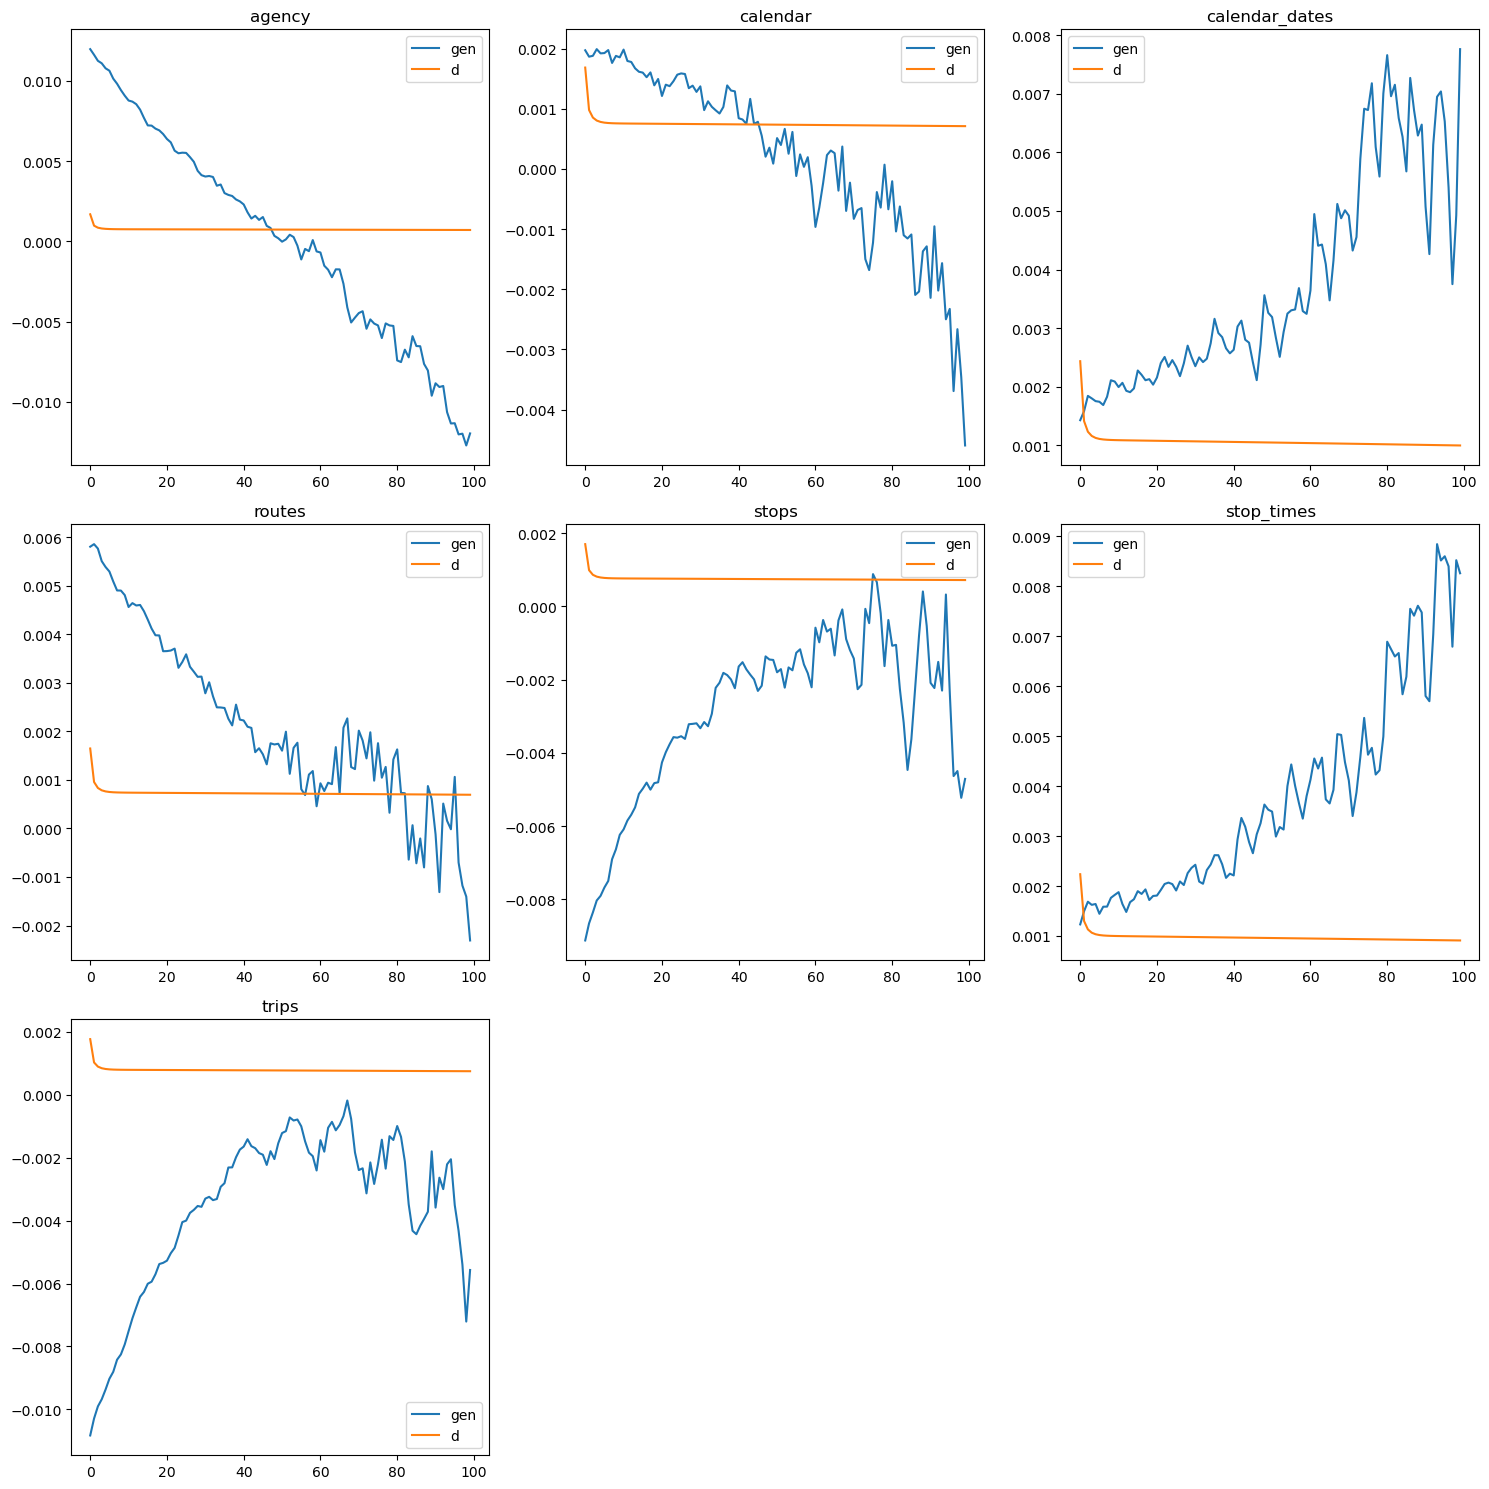

Total Time Used: 3m 56s


In [59]:
collection_training(processed_data_collection, training_parameter_dict)

# Synthetic Data Generation

In [60]:
# table_name:
# {'table':table, # df
#  'labels':labels, # df
#  'scaler':scaler, # a scaler object
#  'table_col_names':table_columns, # list of col names
#  'label_col_names':label_columns, # list of col names
#  'metadata':metadata[df_name]} # a metadata dict (see below)

# metadata
# {'primary_key':primary_key, # list, [column names, number_of_unique_ids]
#  'parent':parent, # dict, {parent_name:shared_id_column_name, ...}
#  'child':child} # str, child_name

In [61]:
# def generate_individual_synth_data(generator, labels, seed=123):
#     pass

In [62]:
# def resample_array(array, size):
#     og_size = len(array)
#     x_og = np.linspace(0, 1, og_size)
#     x_new = np.linspace(0, 1, size)
#     array_resampled = np.interp(x_new, x_og, array)
#     return array_resampled.astype(int)

In [63]:
def generate_new_array(size, unique_elements, prob_distribution):
    new_array = np.random.choice(unique_elements, size=size, p=prob_distribution)
    return new_array

In [116]:
def generate_synth_data_collection(processed_data_collection, sdv_metadata, generation_dict, latent_dim=50, seed=123):
    np.random.seed(seed)
    synthetic_data_collection = {}
    features_to_ignore_rounding = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']
    for df_name, content in processed_data_collection.items():
        generator = models.load_model('models/'+df_name+'_gen.h5')
        primary_key = content['metadata']['primary_key']
        child = content['metadata']['child']
        parent = content['metadata']['parent']
        fake_labels_df_dict = {}
        if primary_key != []:
            primary_key_col = primary_key[0]
            n_primary_keys = generation_dict[df_name]['nrows']
            fake_labels_df_dict[primary_key_col] = np.arange(n_primary_keys).tolist()
        if parent != {}:
            for parent_df_name, fr_key in parent.items():
                
                nrows = generation_dict[df_name]['nrows']
                unique_id = content['metadata']['key_distribution'][fr_key]['unique_values']
                distribution = content['metadata']['key_distribution'][fr_key]['pdf']
                fake_labels_df_dict[fr_key] = generate_new_array(nrows, unique_id, distribution)
                
                # length = generation_dict[df_name]['nrows']
                # parent_df = processed_data_collection[parent_df_name]['labels'][fr_key]
                # fake_labels_df_dict[fr_key] = resample_array(parent_df, length)
                
                # length = generation_dict[df_name]['nrows']
                # parent_df = processed_data_collection[parent_df_name]
                # kde = gaussian_kde(parent_df['labels'][fr_key].to_numpy())
                # lower_bound = parent_df['labels'][fr_key].min()
                # upper_bound = parent_df['labels'][fr_key].max()
                # fake_array = kde.resample(length).flatten()
                # fake_labels_df_dict[fr_key] = np.round(fake_array).clip(lower_bound, upper_bound).astype(int)
                
                # n_foreign_primary_keys = generation_dict[parent_df_name]['nrows']
                # length = generation_dict[df_name]['nrows']
                # fake_labels_df_dict[fr_key] = np.random.randint(0, n_foreign_primary_keys, length).tolist()
        
        if content['metadata']['is_sequential'] == True:
            for additional_key in content['metadata']['additional_key']:
                nrows = generation_dict[df_name]['nrows']
                unique_id = content['metadata']['key_distribution'][additional_key]['unique_values']
                distribution = content['metadata']['key_distribution'][additional_key]['pdf']
                fake_labels_df_dict[additional_key] = generate_new_array(nrows, unique_id, distribution)
        
        fake_labels_df = pd.DataFrame(fake_labels_df_dict).reindex(columns=content['labels_col_names'])
        if content['metadata']['is_sequential'] == True:
            fake_labels_df = fake_labels_df.sort_values(by=content['metadata']['sort_order'])
        scaled_fake_labels_df = pd.DataFrame(content['labels_scaler'].transform(fake_labels_df), columns=content['labels_col_names'])
        latent_dim = (content['table'].shape[1] + content['labels'].shape[1]) * content['labels'].shape[1]
        noise = np.random.uniform(-1, 1, size=(generation_dict[df_name]['nrows'], latent_dim))
        raw_fake_table = generator.predict([noise, scaled_fake_labels_df])
        scaled_fake_table = content['table_scaler'].inverse_transform(raw_fake_table)
        fake_table_df = pd.DataFrame(scaled_fake_table, columns=content['table_col_names'])
        fake_data = pd.concat([fake_labels_df, fake_table_df], axis=1)
        
        columns_to_int = [col for col in fake_data.columns if col not in features_to_ignore_rounding]
        for col in columns_to_int:
            fake_data[col] = fake_data[col].astype(int)
                
        synthetic_data_collection[df_name] = fake_data
        
    return synthetic_data_collection

In [117]:
# def generate_synth_data_collection(processed_data_collection, sdv_metadata, generation_dict, latent_dim=50, seed=123):
#     np.random.seed(seed)
#     synthetic_data_collection = {}
#     features_to_ignore_rounding = ['shape_pt_lat',
#                       'shape_pt_lon',
#                       'stop_lat',
#                       'stop_lon',
#                      'shape_dist_traveled']
    
#     primary_keys = {}
#     for relationship in sdv_metadata.relationships:
#         parent_table_name = relationship['parent_table_name']
#         parent_primary_key = relationship['parent_primary_key']

#         if parent_table_name not in primary_keys:
#             n_rows = generation_dict[parent_table_name]['nrows']
#             primary_keys[parent_table_name] = np.arange(n_rows)

#     # Generate foreign key arrays for each child table
#     foreign_keys = {}
#     for relationship in sdv_metadata.relationships:
#         child_table_name = relationship['child_table_name']
#         child_foreign_key = relationship['child_foreign_key']
#         parent_table_name = relationship['parent_table_name']
#         parent_primary_key = relationship['parent_primary_key']

#         if child_table_name not in foreign_keys:
#             foreign_keys[child_table_name] = {}

#         n_rows = generation_dict[child_table_name]['nrows']
#         prob_distribution = processed_data_collection[parent_table_name]['labels_pdf'][child_foreign_key]
#         foreign_keys[child_table_name][child_foreign_key] = np.random.choice(primary_keys[parent_table_name], n_rows, p=prob_distribution)

#     # Create individual dataframes for each table
#     key_columns_dict = {}
#     for table_name, n_rows in generation_dict.items():
#         key_columns = {}

#         if table_name in primary_keys:
#             key_columns.update({processed_data_collection[table_name]['metadata']['primary_key'][0]: primary_keys[table_name]})

#         if table_name in foreign_keys:
#             key_columns.update(foreign_keys[table_name])
        
#         if processed_data_collection[table_name]['metadata']['is_sequential'] == True:
#             for additional_key in processed_data_collection[table_name]['metadata']['additional_key']:
#                 additional_prob_distribution = processed_data_collection[table_name]['labels_pdf'][additional_key]
#                 key_columns[additional_key] = np.random.choice(np.unique(processed_data_collection[table_name]['labels'][additional_key]), generation_dict[table_name]['nrows'], p=additional_prob_distribution)
        
#         key_columns = pd.DataFrame(key_columns)
#         key_columns_dict[table_name] = key_columns.reindex(columns=processed_data_collection[table_name]['labels_col_names'])
        
#     # generate data
#     for df_name, content in processed_data_collection.items():
#         generator = models.load_model('models/'+df_name+'_gen.h5')
#         latent_dim = (content['table'].shape[1] + content['labels'].shape[1]) * content['labels'].shape[1]
#         noise = np.random.uniform(-1, 1, size=(generation_dict[df_name]['nrows'], latent_dim))
#         raw_fake_table = generator.predict([noise,key_columns_dict[df_name]])
#         fake_table = content['table_scaler'].inverse_transform(raw_fake_table)
#         fake_table = pd.DataFrame(fake_table, columns=content['table_col_names'])
#         fake_data = pd.concat([key_columns_dict[df_name], fake_table], axis=1)
#         fake_data = fake_data.reindex(columns=processed_data_collection[df_name]['col_names'])
        
#         columns_to_int = [col for col in fake_data.columns if col not in features_to_ignore_rounding]
#         for col in columns_to_int:
#             fake_data[col] = fake_data[col].astype(int)

#         synthetic_data_collection[df_name] = fake_data
        
#     return synthetic_data_collection

In [118]:
generation_dict = {k:{'nrows':len(v['table']), 'is_sequential':False} for k,v in processed_data_collection.items()}
generation_dict['calendar_dates']['is_sequential'] = True
generation_dict['stop_times']['is_sequential'] = True
generation_dict['calendar_dates']['sort_by'] = ['service_id','date']
generation_dict['stop_times']['sort_by'] = ['trip_id','stop_sequence']

In [119]:
generation_dict

{'agency': {'nrows': 15, 'is_sequential': False},
 'calendar': {'nrows': 121, 'is_sequential': False},
 'calendar_dates': {'nrows': 674,
  'is_sequential': True,
  'sort_by': ['service_id', 'date']},
 'routes': {'nrows': 215, 'is_sequential': False},
 'stops': {'nrows': 6714, 'is_sequential': False},
 'stop_times': {'nrows': 966790,
  'is_sequential': True,
  'sort_by': ['trip_id', 'stop_sequence']},
 'trips': {'nrows': 32403, 'is_sequential': False}}

In [120]:
%time synthetic_data_collection = generate_synth_data_collection(processed_data_collection, sdv_metadata, generation_dict)

CPU times: total: 1min 21s
Wall time: 1min 7s


In [121]:
# del processed_data_collection

# Metrics

## Pre-metrics Data Processing

In [122]:
# def convert_to_dataframe_collection(processed_data_collection):
#     new_dict = {}
#     features_to_ignore_rounding = ['shape_pt_lat',
#                       'shape_pt_lon',
#                       'stop_lat',
#                       'stop_lon',
#                      'shape_dist_traveled']
#     for df_name, content in processed_data_collection.items():
#         table_scaler = content['table_scaler']
#         labels_scaler = content['labels_scaler']
#         labels = content['labels']
#         table = content['table']
#         table = pd.DataFrame(table_scaler.inverse_transform(table),columns = content['table_col_names'])
#         labels = pd.DataFrame(labels_scaler.inverse_transform(labels),columns = content['labels_col_names'])
#         new_df = pd.concat([labels, table], axis=1)
#         new_df = new_df.reindex(columns=processed_data_collection[df_name]['col_names'])
#         columns_to_int = [col for col in new_df.columns if col not in features_to_ignore_rounding]
#         for col in columns_to_int:
#             new_df[col] = new_df[col].astype(int)
#         new_dict[df_name] = new_df
#     return new_dict

In [123]:
# real_data_collection = convert_to_dataframe_collection(processed_data_collection)

In [124]:
synthetic_data_collection

{'agency':     agency_id  agency_url  agency_timezone  agency_lang  agency_phone
 0           0           0                0            0             0
 1           1           0                0            0             0
 2           2           0                0            0             0
 3           3           0                0            0             0
 4           4           0                0            0             0
 5           5           0                0            0             0
 6           6           0                0            0             0
 7           7           0                0            0             0
 8           8           0                0            0             0
 9           9           0                0            0             0
 10         10           0                0            0             0
 11         11           0                0            0             0
 12         12           0                0            0           

In [125]:
real_data_collection

{'agency':     agency_id  agency_url  agency_timezone  agency_lang  agency_phone
 0           0           0                0            0             0
 1           1           0                0            0             0
 2           2           0                0            0             0
 3           3           0                0            0             0
 4           4           0                0            0             0
 5           5           0                0            0             0
 6           6           0                0            0             0
 7           7           0                0            0             0
 8           8           0                0            0             0
 9           9           0                0            0             0
 10         10           0                0            0             0
 11         11           0                0            0             0
 12         12           0                0            0           

### Cosine Similarity Test

In [126]:
def cos_test(df1, df2):
    cos_sim = metrics.pairwise.cosine_similarity(df1.values.T, df2.values.T)
    mean_cos_sim = np.mean(cos_sim)
    return mean_cos_sim

In [127]:
def batch_cos_test(fake_collection, real_collection):
    test_dict = {}
    for df_name in fake_collection.keys():
        mean_cos_sim = cos_test(real_collection[df_name], fake_collection[df_name])
        test_dict[df_name] = str(round((1-mean_cos_sim)*100, 1)) + '% Similar'
    return test_dict

In [128]:
%time batch_cos_test(synthetic_data_collection, real_data_collection)

CPU times: total: 2 s
Wall time: 252 ms


{'agency': '96.0% Similar',
 'calendar': '79.7% Similar',
 'calendar_dates': '10.5% Similar',
 'routes': '66.3% Similar',
 'stops': '82.8% Similar',
 'stop_times': '57.4% Similar',
 'trips': '65.7% Similar'}

### Inverse KS (Kolmogorov-Smirnov) Test

In [129]:
# def batch_ks_test(fake_collection, real_collection):
#     stats_dict = {}
#     for df_name, fake_df in fake_collection.items():
#         stats_list = []
#         p_val_list = []
#         test_dict = {}
#         for col in fake_df.columns:
#             stats, p_val = ks_2samp(fake_df[col], real_collection[df_name][col], alternative='two-sided', method='auto')
#             stats_list.append(stats)
#             p_val_list.append(p_val)
#         test_dict['stats'] = np.mean(stats_list)
#         test_dict['p_value'] = np.mean(p_val_list)
#         stats_dict[df_name] = test_dict
#     return stats_dict

In [130]:
def ks_test(df1, df2):
    ks_stats = []
    # wasserstein_distances = []
    p_values = []
    for column in df1.columns:
        ks_stat, ks_p_value = ks_2samp(df1[column], df2[column])
        ks_stats.append(ks_stat)
        p_values.append(ks_p_value)
        # w_dist = wasserstein_distance(df1[column], df2[column])
        # wasserstein_distances.append(w_dist)
    mean_ks_stat = np.mean(ks_stats)
    # mean_wasserstein_distance = np.mean(wasserstein_distances)
    mean_p_value = np.mean(p_values)
    return mean_ks_stat, mean_p_value

In [131]:
def batch_ks_test(collection1, collection2):
    stats_dict = {}
    for df_name in collection1:
        ks_results, p_value = ks_test(collection1[df_name], collection2[df_name])
        stats_dict[df_name] = str(round((1-ks_results)*100, 1)) + '% similar in distribution'
    return stats_dict

In [132]:
%time batch_ks_test(synthetic_data_collection, real_data_collection)

CPU times: total: 3.3 s
Wall time: 2.43 s


{'agency': '100.0% similar in distribution',
 'calendar': '57.4% similar in distribution',
 'calendar_dates': '78.8% similar in distribution',
 'routes': '53.6% similar in distribution',
 'stops': '48.5% similar in distribution',
 'stop_times': '69.9% similar in distribution',
 'trips': '82.2% similar in distribution'}

# SDV Individual Table Metrics

In [133]:
# individual_report_collection = {}
# for df_name in real_data_collection.keys():
#     individual_report_collection[df_name] = evaluate_quality(
#         real_data=real_data_collection[df_name],
#         synthetic_data=synthetic_data_collection[df_name],
#         metadata=sdv_metadata.tables[df_name])

In [134]:
# individual_diagnostic_collection = {}
# for df_name in real_data_collection.keys():
#     individual_diagnostic_collection[df_name] = run_diagnostic(
#         real_data=real_data_collection[df_name],
#         synthetic_data=synthetic_data_collection[df_name],
#         metadata=sdv_metadata.tables[df_name])

# SDV Multi-Table Metrics

In [135]:
%%time 
mt_quality_report = evaluate_quality(
    real_data=real_data_collection,
    synthetic_data=synthetic_data_collection,
    metadata=sdv_metadata)

Creating report: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.33s/it]



Overall Quality Score: 46.28%

Properties:
Column Shapes: 58.25%
Column Pair Trends: 33.52%
Parent Child Relationships: 47.06%
CPU times: total: 1min 37s
Wall time: 1min 32s


In [136]:
%%time 
mt_diagnostic_report = run_diagnostic(
    real_data=real_data_collection,
    synthetic_data=synthetic_data_collection,
    metadata=sdv_metadata)

Creating report: 100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.70it/s]


DiagnosticResults:

SUCCESS:
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data
! The synthetic data is missing more than 10% of the categories present in the real data

DANGER:
x More than 50% of the synthetic rows are copies of the real data
CPU times: total: 594 ms
Wall time: 602 ms


# Join Test

## Join Data

In [137]:
def auto_join(df_list, how='inner'):
    result = df_list[0]
    for df in df_list[1:]:
        shared_columns = list(set(result.columns) & set(df.columns))
        if not shared_columns:
            continue
        result = result.merge(df, on=shared_columns, how=how)
    return result

In [138]:
df_list = [synthetic_data_collection['routes'], synthetic_data_collection['trips']]
fake_routes_trips = auto_join(df_list, how='inner')

In [139]:
df_list = [synthetic_data_collection['stops'], synthetic_data_collection['stop_times'], synthetic_data_collection['trips']]
fake_stops_stop_times_trips = auto_join(df_list, how='inner')

In [140]:
df_list = [real_data_collection['routes'], real_data_collection['trips']]
real_routes_trips = auto_join(df_list, how='inner')

In [141]:
df_list = [real_data_collection['stops'], real_data_collection['stop_times'], real_data_collection['trips']]
real_stops_stop_times_trips = auto_join(df_list, how='inner')

## Measue # of Rows Abandoned

In [142]:
def leftout_percentage(df1, df2):
    df1_len = len(df1)
    df2_len = len(df2)
    min_ = min(df1_len, df2_len)
    max_ = max(df1_len, df2_len)
    leftout = (((max_ - min_) / max_) + ((max_ - min_) / min_)) / 2
    return leftout

In [143]:
leftout_percentage(fake_routes_trips, real_routes_trips)

0.0

In [144]:
leftout_percentage(fake_stops_stop_times_trips, real_stops_stop_times_trips)

0.0

## CosSim Test For Joined Data

In [145]:
min_ = min(len(fake_routes_trips), len(real_routes_trips))
cos_test_result = []
for i in range(10):
    seed = 123
    cos_test_result.append(cos_test(fake_routes_trips.sample(min_, random_state=seed), real_routes_trips.sample(min_, random_state=seed)))
    seed += 1
cos_test_result = str(round((1-np.mean(cos_test_result))*100, 1)) + '% similar'
cos_test_result

'66.9% similar'

In [146]:
min_ = min(len(fake_stops_stop_times_trips), len(real_stops_stop_times_trips))
cos_test_result = []
for i in range(10):
    seed = 123
    cos_test_result.append(cos_test(fake_stops_stop_times_trips.sample(min_, random_state=seed), real_stops_stop_times_trips.sample(min_, random_state=seed)))
    seed += 1
cos_test_result = str(round((1-np.mean(cos_test_result))*100, 1)) + '% similar'
cos_test_result

'71.5% similar'

## KS Test For Joined Data

In [147]:
min_ = min(len(fake_routes_trips), len(real_routes_trips))
ks_test_result = []
ks_stats = []
p_values = []
for i in range(10):
    seed = 123
    ks_stat, p_value = ks_test(fake_routes_trips.sample(min_, random_state=seed), real_routes_trips.sample(min_, random_state=seed))
    ks_stats.append(ks_stat)
    p_values.append(p_value)
    seed += 1
ks_test_result.append(str(round((1-np.mean(np.mean(ks_stats)))*100, 1)) + '% similar in distribution')
ks_test_result.append(np.mean(p_values))

In [148]:
print(f'statistics: {ks_test_result[0]}')

statistics: 69.5% similar in distribution


In [149]:
min_ = min(len(fake_stops_stop_times_trips), len(real_stops_stop_times_trips))
ks_test_result = []
ks_stats = []
p_values = []
for i in range(10):
    seed = 123
    ks_stat, p_value = ks_test(fake_stops_stop_times_trips.sample(min_, random_state=seed), real_stops_stop_times_trips.sample(min_, random_state=seed))
    ks_stats.append(ks_stat)
    p_values.append(p_value)
    seed += 1
ks_test_result.append(str(round((1-np.mean(np.mean(ks_stats)))*100, 1)) + '% similar in distribution')
ks_test_result.append(np.mean(p_values))

In [150]:
print(f'statistics: {ks_test_result[0]}')

statistics: 63.5% similar in distribution


# CTGAN

In [151]:
# def collection_gtgan_training(data_collection, multi_metadata):
#     generator_dict = {}
#     for df_name, df in data_collection.items():
#         synthesizer = CTGANSynthesizer(
#             multi_metadata.tables[df_name],
#             enforce_rounding=False,
#             epochs=100,
#             verbose=True,
#             batch_size=130,
#             discriminator_lr = 0.0001,
#             generator_lr = 0.0002
#         )
#         synthesizer.fit(df)
#         synthesizer.save(
#             filepath='models_single/'+df_name+'_ctgan.pkl'
#         )

In [152]:
# collection_gtgan_training(real_data_collection, sdv_metadata)

# CopulaGAN

In [153]:
# def collection_copulagan_training(data_collection, multi_metadata):
#     generator_dict = {}
#     for df_name, df in data_collection.items():
#         synthesizer = CopulaGANSynthesizer(
#             multi_metadata.tables[df_name],
#             enforce_min_max_values=True,
#             enforce_rounding=False,
#             epochs=100,
#             batch_size=130,
#             verbose=True
#         )
#         synthesizer.fit(df)
#         synthesizer.save(
#             filepath='models_single/'+df_name+'_copulagan.pkl'
#         )

In [154]:
# collection_copulagan_training(real_data_collection, sdv_metadata)

# GaussianCopula

In [155]:
# def collection_gaussiancopula_training(data_collection, multi_metadata):
#     generator_dict = {}
#     for df_name, df in data_collection.items():
#         synthesizer = GaussianCopulaSynthesizer(
#             multi_metadata.tables[df_name],
#             enforce_min_max_values=True,
#             enforce_rounding=True,
#             default_distribution='norm',
#         )
#         synthesizer.fit(df)
#         synthesizer.save(
#             filepath='models_single/'+df_name+'_gaussiancopula.pkl'
#         )

In [156]:
# collection_gaussiancopula_training(real_data_collection, sdv_metadata)

In [157]:
# gc_synthetic_data_collection = {}
# for df_name, content in generation_dict.items():
#     synthesizer = GaussianCopulaSynthesizer.load(
#         filepath='models_single/'+df_name+'_gaussiancopula.pkl'
#     )
#     gc_synthetic_data_collection[df_name] = synthesizer.sample(
#         num_rows=content['nrows']
#     )

In [158]:
# gc_synthetic_data_collection

In [159]:
# cos_test(gc_synthetic_data_collection, real_data_collection)

In [160]:
# batch_ks_test(gc_synthetic_data_collection, real_data_collection)

# TVAE

In [161]:
# def collection_tvae_training(data_collection, multi_metadata):
#     generator_dict = {}
#     for df_name, df in data_collection.items():
#         synthesizer = TVAESynthesizer(
#             multi_metadata.tables[df_name],
#             enforce_min_max_values=True,
#             enforce_rounding=False,
#             epochs=100,
#             batch_size=130
#         )
#         synthesizer.fit(df)
#         synthesizer.save(
#             filepath='models_single/'+df_name+'_tvae.pkl'
#         )

In [162]:
# collection_tvae_training(real_data_collection, sdv_metadata)

In [163]:
# tvae_synthetic_data_collection = {}
# for df_name, content in generation_dict.items():
#     synthesizer = TVAESynthesizer.load(
#         filepath='models_single/'+df_name+'_tvae.pkl'
#     )
#     tvae_synthetic_data_collection[df_name] = synthesizer.sample(
#         num_rows=content['nrows']
#     )

# HMA

In [164]:
# synthesizer = HMASynthesizer(sdv_metadata)
# synthesizer.fit(real_data_collection)